In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
sns.set_style("darkgrid")

In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

# Read and Split the Data

In [3]:
weather=pd.read_csv('weather2.csv')
readings=pd.read_csv('readings.csv')

In [4]:
chicago=pd.merge(readings, weather, on='Date').drop(['Date', 'Month', 'Year'], axis=1);
print(chicago.shape)
chicago.head()

(10506, 12)


,Virus,DayRunner,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,near_hotspot,near_chompspot,avg_rain1,avg_rain2,avg_dry1,avg_dry2
0,0,149,0,0,1,0,5,3,0.714286,0.428571,0.857143,0.571429
1,0,149,0,0,0,1,5,3,0.714286,0.428571,0.857143,0.571429
2,0,149,0,0,0,1,3,2,0.714286,0.428571,0.857143,0.571429
3,0,149,0,0,1,0,5,3,0.714286,0.428571,0.857143,0.571429
4,0,149,0,0,0,1,5,3,0.714286,0.428571,0.857143,0.571429


In [5]:
# Split the data
X = chicago.drop(['Virus'], axis=1)
y = chicago['Virus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train.shape # Notice the number of rows in the training set. This should stay constant.

(8404, 11)

# Model 1. KNN classifier 

#### fit on the training, predict on the testing data

In [6]:
# train the model
neighs = KNeighborsClassifier(n_neighbors=7)
knn_model = neighs.fit(X_train, y_train)

In [7]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(knn_model, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.94324203871505452, 0.0022898842121303721)

In [8]:
# Predict the y values on the testing data.
y_hat = knn_model.predict(X_test)

#### Score my model

In [9]:
# Set up some empty lists, so we can compare our models at the end
acc=[]
sens=[]
spec=[]
roc=[]

In [10]:
# There are two different ways to get the accuracy score, which is our primary metric:
modscore=100*(knn_model.score(X_test, y_test))
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(modscore)
print(accuracy)

94.4338725024
94.4338725024


In [11]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1983    9]
 [ 108    2]]


In [12]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 1.81818181818
specificity: 99.5481927711


In [13]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

50.6831872946


# Model 2. Logistic Classifier

#### fit on the training, predict on the testing data

In [14]:
# train the model
logit = LogisticRegression()
log_model=logit.fit(X_train, y_train)

In [15]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(logit, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.94752506261675329, 0.0002195732545577469)

In [16]:
# Predict the y values on the testing data.
y_hat = log_model.predict(X_test)

In [17]:
# Check out the coefficients
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(log_model.coef_))], axis = 1)
coefficients

,0,0
0,DayRunner,0.006782
1,ALTER,-1.909584
2,PIPIENS,0.377304
3,PIPIENS-RESTUANS,-0.197407
4,RESTUANS,-1.298557
5,near_hotspot,0.144495
6,near_chompspot,0.087639
7,avg_rain1,-0.185287
8,avg_rain2,-1.086604
9,avg_dry1,-0.962501


#### Score my model

In [18]:
# There are two different ways to get the accuracy score, which is our primary metric:
modscore=100*(log_model.score(X_test, y_test))
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(modscore)
print(accuracy)

94.7668886775
94.7668886775


In [19]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1992    0]
 [ 110    0]]


In [20]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 100.0


In [21]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

50.0


# Model 3. Random Forest Classifier

#### Instantiate and Fit the Model

In [22]:
dt = RandomForestClassifier()
tree_model=dt.fit(X_train, y_train)

In [23]:
# The crossvalidiation score scores our performance on the training data. It's quite high (but we have imbalance)
scores = cross_val_score(tree_model, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.93598112551068802, 0.0041244317719956267)

In [24]:
# Predict the y values on the testing data.
y_hat = tree_model.predict(X_test)

#### Score the model

In [25]:
# ACCURACY
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(accuracy)

94.2435775452


In [26]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1974   18]
 [ 103    7]]


In [27]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 6.36363636364
specificity: 99.0963855422


In [28]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

52.7300109529


In [29]:
# compute the feature importances
importances = tree_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 5 (0.290799)
2. feature 6 (0.257698)
3. feature 0 (0.153731)
4. feature 10 (0.062759)
5. feature 8 (0.052381)
6. feature 9 (0.051730)
7. feature 7 (0.050903)
8. feature 2 (0.035033)
9. feature 3 (0.025606)
10. feature 4 (0.016404)
11. feature 1 (0.002957)


In [30]:
len(importances)

11

In [31]:
feat_imp=pd.DataFrame(importances, index=X_test.columns, columns=['importance'])
feat_imp['importance'].sort_values(ascending=False).head(15)

near_hotspot        0.290799
near_chompspot      0.257698
DayRunner           0.153731
avg_dry2            0.062759
avg_rain2           0.052381
avg_dry1            0.051730
avg_rain1           0.050903
PIPIENS             0.035033
PIPIENS-RESTUANS    0.025606
RESTUANS            0.016404
ALTER               0.002957
Name: importance, dtype: float64

In [32]:
top15=pd.DataFrame(feat_imp['importance'].sort_values(ascending=False))

Text(0,0.5,'Feature Importance')

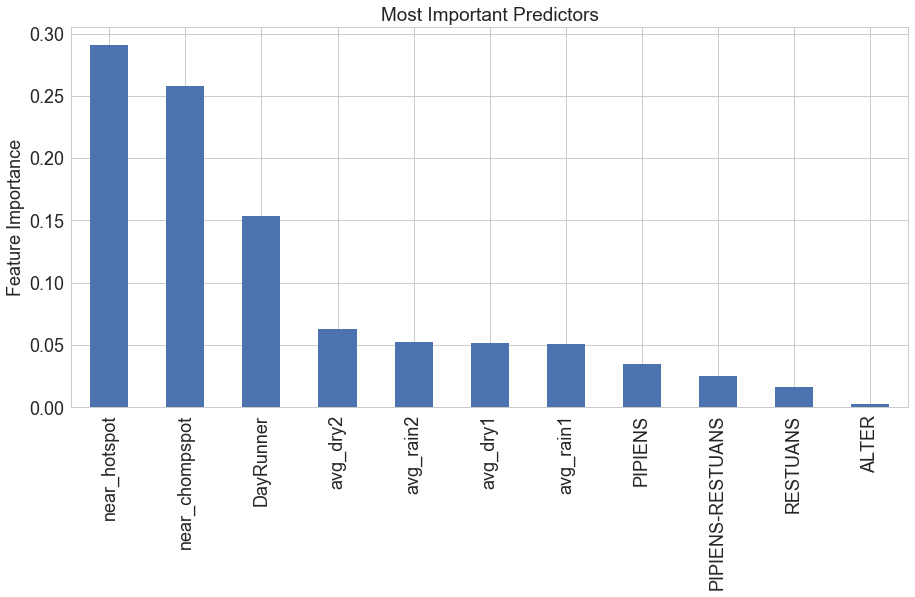

In [33]:
sns.set(style="whitegrid", color_codes=True)
ax = top15.plot(kind='bar', legend=False, fontsize=18, figsize=(15, 7))
plt.xticks(rotation = 90,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18) 

# Compare Models

In [34]:
# Recap those scores for me, please.
models=['KNN', 'Logistic', 'Random Forest']
cols=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'ROC-AUC']
print(acc)
print(sens)
print(spec)
print(roc)

[94.433872502378691, 94.766888677450041, 94.243577545195052]
[1.8181818181818181, 0.0, 6.3636363636363633]
[99.548192771084331, 100.0, 99.096385542168676]
[50.683187294633079, 50.0, 52.730010952902518]


In [35]:
# Show me that in a table:
model_scores=pd.DataFrame(list(map(list, zip(models, acc, sens, spec, roc))), columns=cols)
model_scores

,Model,Accuracy,Sensitivity,Specificity,ROC-AUC
0,KNN,94.433873,1.818182,99.548193,50.683187
1,Logistic,94.766889,0.000000,100.000000,50.000000
2,Random Forest,94.243578,6.363636,99.096386,52.730011


Text(0,0.5,'Score')

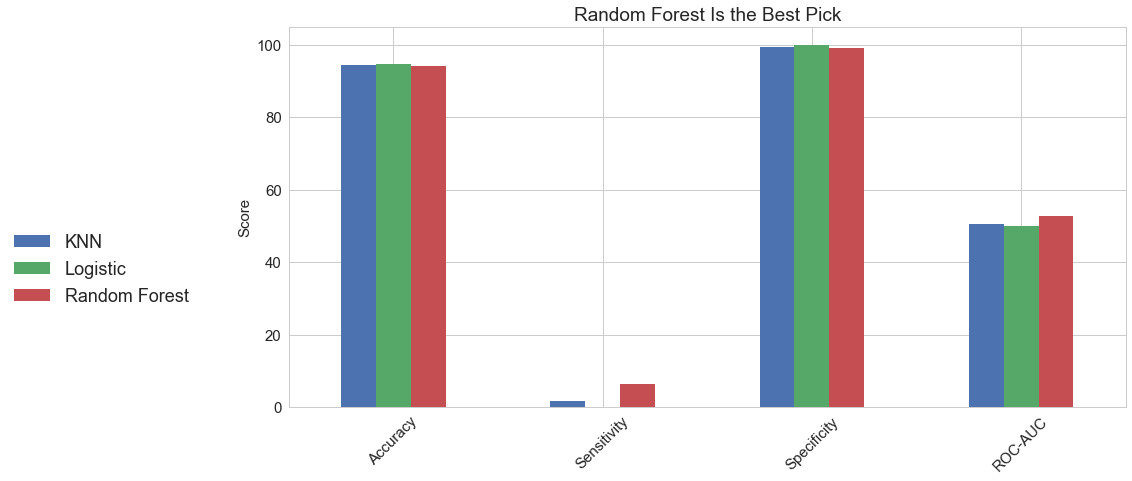

In [36]:
# Make it pretty. 
ax = model_scores.set_index('Model').T.plot(kind='bar', legend=False, fontsize=12, figsize=(15, 7))
ax.legend(loc=1, fontsize=18, bbox_to_anchor=(-0.1, 0.5))
plt.xticks(rotation = 45,  fontsize=15)
plt.title('Random Forest Is the Best Pick',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=15)
plt.ylabel('Score', rotation=90,  fontsize=15)  

## Pickle Time

In [37]:
import pickle

with open('tree_model.pickle', 'wb') as f:
    pickle.dump(tree_model, f, protocol=0)

In [38]:
print(len(X_train.columns))
X_train.columns

11


Index(['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2'],
      dtype='object')